In [1]:
import json
with open('saved_model/model_subscriptions.json','r') as f:
    models_info = json.load(f)

In [2]:
import torch
from model import UNet3d
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3d(in_channels=3, n_classes=3, n_channels=32)
model_name = 'interval_3'
model_info = next((model for model in models_info if model['model_name'] == model_name), None)
print(model_info)
model.load_state_dict(torch.load(f'saved_model/best-{model_name}.pth'))
model = model.to(device)
model.eval()

{'model_name': 'interval_3', 'epoch': 200, 'batch_size': 4, 'resize_info': [0, 155, 3], 'resized_depth': 52, 'best_model_path': 'saved_model/best-interval_3.pth', 'latest_model_path': 'saved_model/latest-interval_3.pth', 'csv_log_path': 'logs/train_log(interval_3).csv', 'plot_path': 'logs/plot-interval_3.jpg', 'resize map path': 'saved_model/slicing_map_interval_3.json', 'run time(s)': 75367.66466188431}


UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 32, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (

In [3]:
from utils import get_dataloader,preprocess_mask_labels
from dataset import BratsDataset
import os
import nibabel as nib
import numpy as np
val_dataloader = get_dataloader(dataset=BratsDataset, phase="val", resize_info=model_info['resize_info'])
len(val_dataloader)
test_batch = next(iter(val_dataloader))
batch_id, images, targets = test_batch['Id'], test_batch['image'], test_batch['mask']
images = images.to(device)
targets = targets.to(device)
print('batch id',batch_id)
print('loaded image, target shape',images.shape, targets.shape)
targets = targets[0]
targets = targets.detach().cpu().numpy()

id_ = batch_id[0]
_whole_slices = nib.load(os.path.join('brats_data', 'val', id_, id_+'-seg.nii.gz'))
_whole_slices = np.asarray(_whole_slices.dataobj) #(240,240,155)
_whole_slices = _whole_slices.transpose(2,0,1)
whole_slices = preprocess_mask_labels(_whole_slices)
print("after preprocess", whole_slices.shape)

batch id ['BraTS-GLI-00707-000', 'BraTS-GLI-00210-000', 'BraTS-GLI-01427-000', 'BraTS-GLI-00818-000']
loaded image, target shape torch.Size([4, 3, 52, 120, 120]) torch.Size([4, 3, 52, 120, 120])
before preprocess (155, 240, 240)
after preprocess (3, 155, 240, 240)


In [4]:
from skimage.transform import resize

with torch.no_grad():
    logits = model(images[0].unsqueeze(0))
    pred = torch.sigmoid(logits).detach().cpu().numpy()
    threshold = 0.33
    pred = (pred >= threshold).astype(int)
    print("min/max:",pred.min(),'/', pred.max(), ', predicttion shape:',pred.shape)
pred = pred[0] # first of batches
resized_pred = resize(pred,(3,155,240,240), preserve_range=True) #(3,155,240,240)
print('before: ',pred.shape, 'after:',resized_pred.shape)

min/max: 0 / 1 , predicttion shape: (1, 3, 52, 120, 120)
before:  (3, 52, 120, 120) after: (3, 155, 240, 240)


In [5]:
mask_set = {
    "WT": targets[0],
    "TC": targets[1],
    "ET": targets[2],
}
pred_set = {
    "WT": pred[0],
    "TC": pred[1],
    "ET": pred[2],
}
ori_mask_set = {
    "WT": whole_slices[0],
    "TC": whole_slices[1],
    "ET": whole_slices[2],
}
ori_pred_set = {
    "WT": resized_pred[0],
    "TC": resized_pred[1],
    "ET": resized_pred[2],
}
print(mask_set["WT"].shape,pred_set["WT"].shape,ori_mask_set["WT"].shape,ori_pred_set["WT"].shape)

(52, 120, 120) (52, 120, 120) (155, 240, 240) (155, 240, 240)


In [6]:
import matplotlib.pyplot as plt
def comp_gt_pred(percent, slices, gt, pred):
    slide2show = int(percent/100*slices)
    print(slide2show)
    plt.suptitle(f"Compare at slice {slide2show}/{slices}({percent}%)")
    for i,clas in enumerate(gt):
        plt.subplot(2,3,i+1)
        plt.title(f'GT of {clas}')
        plt.imshow(gt[clas][slide2show], cmap='gray')
        plt.axis('off')
        plt.subplot(2,3,i+1+3)
        plt.title(f'prediction of {clas}')
        plt.axis('off')
        plt.imshow(pred[clas][slide2show], cmap='gray')
    plt.show()

15


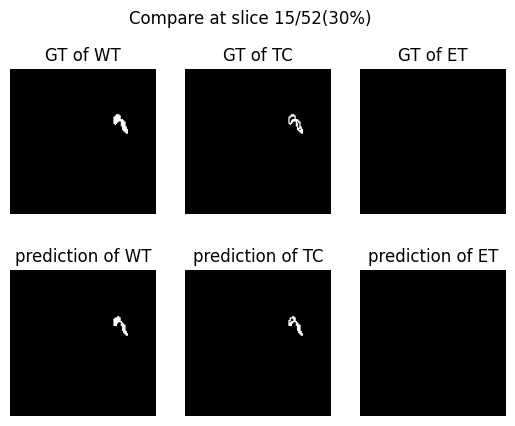

17


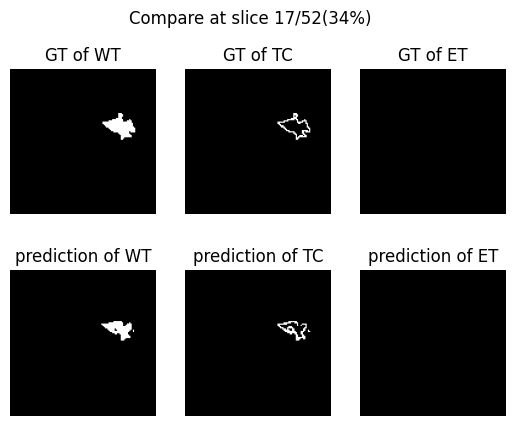

19


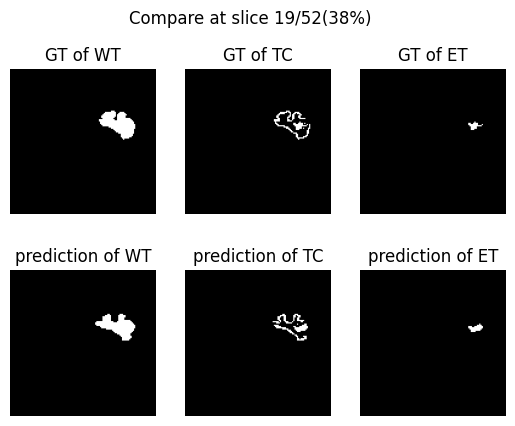

21


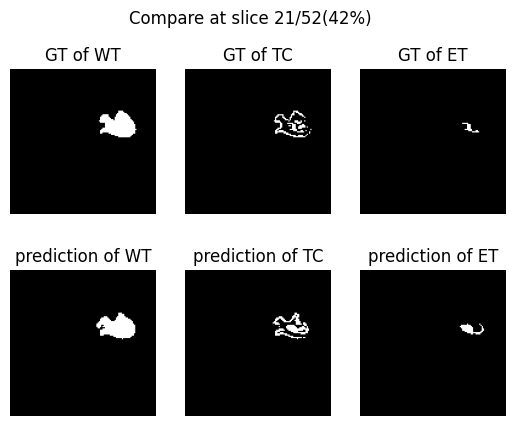

23


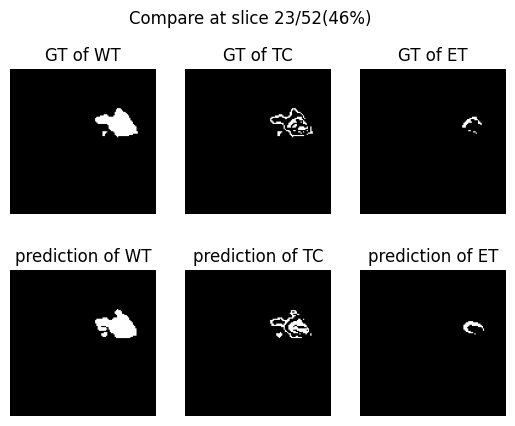

In [7]:
for percent in range(30,50,4):
    comp_gt_pred(percent,model_info['resized_depth'], mask_set, pred_set)

46


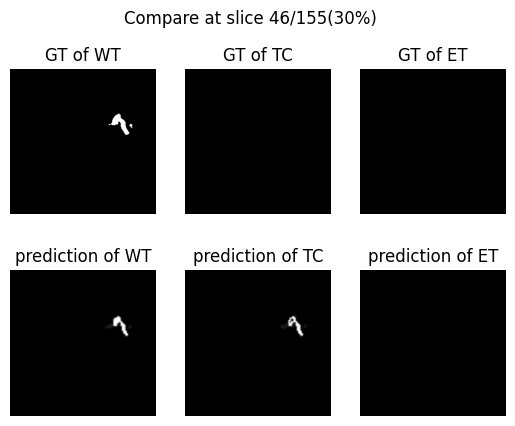

52


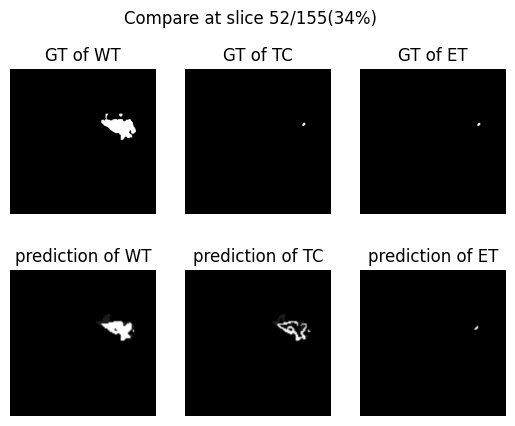

58


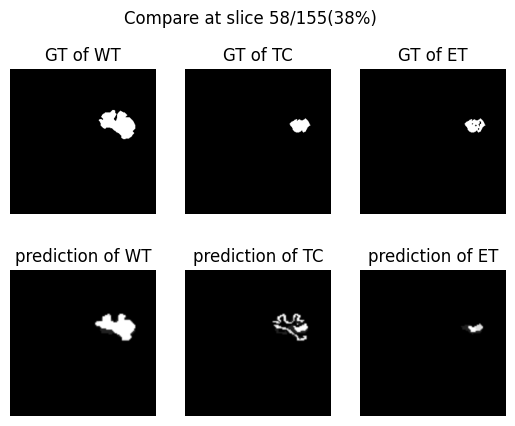

65


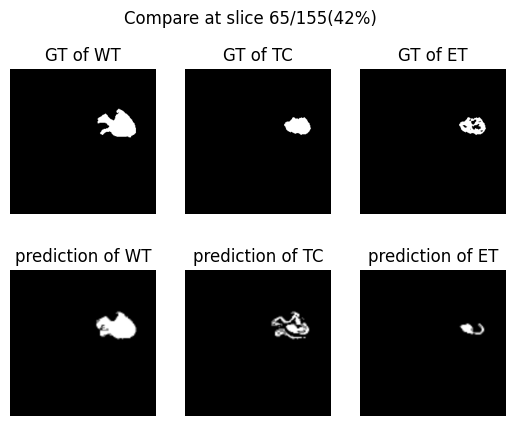

71


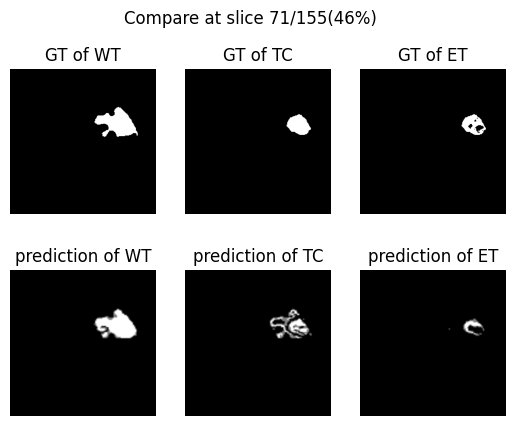

In [8]:
for percent in range(30,50,4):
    comp_gt_pred(percent,155, ori_mask_set, ori_pred_set)

In [9]:
from eval_utils import compute_dice

In [16]:
def slice_per_dice(slice2show):
    score_dict = {'inverval-3':{},'original':{}}
    for clas in mask_set:
        score = compute_dice(mask_set[clas][slice2show], pred_set[clas][slice2show])
        score_dict['inverval-3'][clas] = score
        ori_score = compute_dice(ori_mask_set[clas][slice2show*3], ori_pred_set[clas][slice2show*3])
        score_dict['original'][clas] = ori_score
    print(slice2show, score_dict)

In [17]:
for i in range(20,30):
    slice_per_dice(i)

20 {'inverval-3': {'WT': 0.920314253647587, 'TC': 0.5789473684210527, 'ET': 0.6407766990291263}, 'original': {'WT': 0.9055727554179567, 'TC': 0.5077633235417541, 'ET': 0.7419354838709677}}
21 {'inverval-3': {'WT': 0.9368770764119602, 'TC': 0.6252983293556086, 'ET': 0.5517241379310345}, 'original': {'WT': 0.8978359335681932, 'TC': 0.5469046714774022, 'ET': 0.753577106518283}}
22 {'inverval-3': {'WT': 0.9273743016759777, 'TC': 0.6276346604215457, 'ET': 0.44036697247706424}, 'original': {'WT': 0.8719112455874937, 'TC': 0.5447843715444157, 'ET': 0.7593582887700535}}
23 {'inverval-3': {'WT': 0.93058568329718, 'TC': 0.6697247706422018, 'ET': 0.5289256198347108}, 'original': {'WT': 0.8665367754505602, 'TC': 0.5786873676781934, 'ET': 0.7489300998573466}}
24 {'inverval-3': {'WT': 0.9410569105691057, 'TC': 0.6948775055679287, 'ET': 0.6714285714285714}, 'original': {'WT': 0.8798529749597979, 'TC': 0.5549664192294097, 'ET': 0.8072992700729927}}
25 {'inverval-3': {'WT': 0.9640718562874252, 'TC': 0.

In [18]:
print('WT',compute_dice(mask_set['WT'],pred_set['WT']))
print('ET',compute_dice(mask_set['ET'],pred_set['ET']))
print('TC',compute_dice(mask_set['TC'],pred_set['TC']))

WT 0.9272884781980941
ET 0.5601539942252165
TC 0.6805063291139241


In [19]:
print('WT',compute_dice(ori_mask_set['WT'],ori_pred_set['WT']))
print('ET',compute_dice(ori_mask_set['ET'],ori_pred_set['ET']))
print('TC',compute_dice(ori_mask_set['TC'],ori_pred_set['TC']))

WT 0.849688041163652
ET 0.7646925602989469
TC 0.28833301797540206
